In [1]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import numpy as np
import os
from skimage.feature import hog
from skimage.color import rgb2gray

Chargement des données d'entraînement


In [2]:
# Chargement des données des patchs normalisés
pos_patch_fs = [
    os.path.splitext(f)[0]
    for f in os.listdir(os.path.join("local_data", "4_normalized_patches", "pos"))
    if f.endswith(".jpg")
]
neg_patch_fs = [
    os.path.splitext(f)[0]
    for f in os.listdir(os.path.join("local_data", "4_normalized_patches", "neg"))
    if f.endswith(".jpg")
]

pos_patchs = {}
neg_patchs = {}

for f in pos_patch_fs:
    try:
        patch = plt.imread(
            os.path.join("local_data", "4_normalized_patches", "pos", f"{f}.jpg")
        )
        pos_patchs[f] = patch[
            :, :, 0
        ]  # le channel grayscale est dupliqué sur les 3 chanaux RGB (on en isole 1)

    except FileNotFoundError:
        continue

for f in neg_patch_fs:
    try:
        patch = plt.imread(
            os.path.join("local_data", "4_normalized_patches", "neg", f"{f}.jpg")
        )
        neg_patchs[f] = patch[
            :, :, 0
        ]  # le channel grayscale est dupliqué sur les 3 chanaux RGB (on en isole 1)

    except FileNotFoundError:
        continue

nb_patchs_tot = len(pos_patchs) + len(neg_patchs)

In [3]:
# Chargement des images ! (on utilse une partie du set d'entraînement comme validation aussi)
# Elles sont grayscale directement
pos_img_fs = [
    os.path.splitext(f)[0]
    for f in os.listdir(
        os.path.join("local_data", "1_data_filtered", "train", "images", "pos")
    )
    if f.endswith(".jpg")
]
neg_img_fs = [
    os.path.splitext(f)[0]
    for f in os.listdir(
        os.path.join("local_data", "1_data_filtered", "train", "images", "neg")
    )
    if f.endswith(".jpg")
]

pos_imgs_rgb = {}
pos_imgs = {}
pos_img_names = []
neg_imgs = {}
neg_imgs_rgb = {}
neg_img_names = []

for f in pos_img_fs:
    try:
        img = plt.imread(
            os.path.join(
                "local_data", "1_data_filtered", "train", "images", "pos", f"{f}.jpg"
            )
        )
        pos_imgs[f] = rgb2gray(img)
        pos_imgs_rgb[f] = img
        pos_img_names.append(f)

    except FileNotFoundError:
        continue

for f in neg_img_fs:
    try:
        img = plt.imread(
            os.path.join(
                "local_data", "1_data_filtered", "train", "images", "neg", f"{f}.jpg"
            )
        )
        neg_imgs[f] = rgb2gray(img)
        neg_imgs_rgb[f] = img
        neg_img_names.append(f)

    except FileNotFoundError:
        continue

nb_imgs_tot = len(pos_imgs) + len(neg_imgs)

In [4]:
# Selection des images d'entraînement et des images de validation (test) parmi celles du dossier train
train_part = 80 / 100

# Mélange des indices, pour que les données soient mélangées "en même temps"
# Et surtout, on fait en sorte de filtrer les patchs d'entraînement du classifieur de sorte qu'il n'y en ait aucun appartenant aux images de test !
rng = np.random.default_rng(seed=0)
idx_pos = np.arange(len(pos_imgs))
idx_neg = np.arange(len(neg_imgs))
rng.shuffle(idx_pos)
rng.shuffle(idx_neg)

pos_img_names_shuffled = np.array(pos_img_names)[idx_pos]

neg_img_names_shuffled = np.array(neg_img_names)[idx_neg]

cutoff_pos = int(train_part * len(pos_imgs))
pos_img_test_names = pos_img_names_shuffled[cutoff_pos:]

cutoff_neg = int(train_part * len(neg_imgs))
neg_img_test_names = neg_img_names_shuffled[cutoff_neg:]

pos_img_test = [pos_imgs[f] for f in pos_img_test_names]
neg_img_test = [neg_imgs[f] for f in neg_img_test_names]

pos_img_test_rgb = [pos_imgs_rgb[f] for f in pos_img_test_names]
neg_img_test_rgb = [neg_imgs_rgb[f] for f in neg_img_test_names]

imgs_test = (
    pos_img_test + neg_img_test
)  # ça nous permet aussi de simplifier notre vérification, on sait que toutes les images positives sont au début

imgs_test_rgb = (pos_img_test_rgb + neg_img_test_rgb)

print("total pos/neg : ", len(pos_imgs), len(neg_imgs))
print("tests pos/neg : ", len(pos_img_test), len(neg_img_test))
print("exemple d'image prise pour le test : ", f"pos/{pos_img_test_names[0]}.jpg")
print("exemple d'image prise pour le test : ", f"neg/{neg_img_test_names[0]}.jpg")

total pos/neg :  313 144
tests pos/neg :  63 29
exemple d'image prise pour le test :  pos/0134.jpg
exemple d'image prise pour le test :  neg/0024.jpg


In [5]:
# Filtre : les patchs servant à l'entraînement sont tous ceux qui n'appartiennent pas aux images de tests

# test_string = "0277_00"
# print(test_string[:4]) # "0277"

pos_patchs_train = np.array(
    [pos_patchs[f] for f in pos_patchs.keys() if f[:4] not in pos_img_test_names]
)
neg_patchs_train = np.array(
    [neg_patchs[f] for f in neg_patchs.keys() if f[:4] not in neg_img_test_names]
)

print(len(pos_patchs), len(neg_patchs))
print(len(pos_patchs_train), len(neg_patchs_train))

y_train = np.hstack(
    [np.ones((1, len(pos_patchs_train))), np.zeros((1, len(neg_patchs_train)))]
).flatten()

patchs_train = np.vstack([pos_patchs_train, neg_patchs_train])
print(patchs_train.shape)
print(y_train.shape)

1204 6020
948 4856
(5804, 128, 72)
(5804,)


In [16]:
# Extraction des features sur les patchs d'entraînement
# TODO : y placer les paramètres optimisés


def HOG_extractor(patchs):
    if len(patchs) == 0:
        return []
    first_features = hog(patchs[0])  # valeurs par défaut
    features = np.zeros(
        shape=(len(patchs), first_features.shape[0]), dtype=first_features.dtype
    )
    for i, patch in enumerate(patchs):
        features[i] = hog(patch)

    return features


X_train = HOG_extractor(patchs_train)
print(X_train.shape)
print(X_train.dtype)

(5804, 7938)
float64


In [7]:
# Entraînement du modèle
# TODO : y placer les paramètres optimisés
# probability=True pour pouvoir utiliser .predict_proba(X) dessus (rajoute pas mal de temps d'entraînement en vrai)

clf = SVC(kernel="poly", probability=True)
clf.fit(X_train, y_train)

SVC(kernel='poly', probability=True)

Autres trucs utiles


In [8]:
import importlib
from functools import partial

module_name = "local_data.4_normalized_patches.normalizer"
normalizer = importlib.import_module(module_name)

# test de si la fonction marche bien ici
target_shape = normalizer.get_target_shape()
normalize_patch = partial(normalizer.normalize_patch, target_shape)
__patch = patchs_train[0]
normalize_patch(__patch)

array([[0.34117647, 0.4745098 , 0.40784314, ..., 0.43921569, 0.33333333,
        0.52156863],
       [0.34117647, 0.41960784, 0.35686275, ..., 0.43529412, 0.41176471,
        0.39607843],
       [0.34901961, 0.37647059, 0.38039216, ..., 0.35686275, 0.38039216,
        0.27843137],
       ...,
       [0.31372549, 0.33333333, 0.36078431, ..., 0.28627451, 0.4       ,
        0.30588235],
       [0.30980392, 0.34117647, 0.37647059, ..., 0.36078431, 0.19607843,
        0.20392157],
       [0.30588235, 0.34509804, 0.38039216, ..., 0.21960784, 0.22745098,
        0.35294118]])

In [9]:
stats = {}
with open(
    os.path.join("local_data", "4_normalized_patches", "stats.txt"),
    "r",
    encoding="utf-8",
) as f:
    for line in f:
        line = line.strip()
        if not line or "=" not in line:
            continue

        key, value = line.split("=", 1)

        try:
            val = float(value)
            if val.is_integer():
                val = int(val)
            stats[key] = val
        except ValueError:
            pass

# Extraction dans des variables individuelles (optionnel)
min_ratio = stats.get("min_ratio")
max_ratio = stats.get("max_ratio")
moy_ratio = stats.get("moy_ratio")
min_scale = stats.get("min_scale")
max_scale = stats.get("max_scale")

print(min_ratio)
print(max_ratio)
print(moy_ratio)
print(min_scale)
print(max_scale)

0.42758620689655175
0.9832214765100671
0.5725892334813942
107
2635


Toutes les variables que tu peux utiliser pour tester ta détection dans la suite


In [10]:
### Trucs globaux

imgs_test  # liste python des images de test (qui sont déjà grayscale, chaque image est une numpy array 2D)
# composée (DANS L'ORDRE !) de 63 images positives (on sait qu'il y a au moins une ecocup) + 29 images négatives

clf  # Le fameux classifieur SVC(kernel="poly") entraîné avec les features extraites grâce à un HOG sur des patchs normalisés
# appartenant seulement aux images d'entraînement, c'est-à-dire que le classifieur "n'a jamais vue" les images de test, même en partie


### Limites de formes des fenêtres de découpe

min_scale  # facteur de scale minimum mesuré dans les bbox d'annotations sur les images positives (c'est-à-dire la longueur du rectangle)
max_scale  # facteur de scale max

min_ratio  # ratio minimum mesuré (rapport entre largeur/hauteur), un ratio petit fait que la fenêtre apparâit plus "carrée"
max_ratio  # ratio maximum mesuré

# Exemple pour obtenir les dimensions de la plus grande fenêtre de test :
# (max_ratio*max_scale, max_scale) : (width, height), la fenêtre apparaît comme un rectangle "debout"
# il faudrait aussi tester le cas inverse :
# (max_scale, max_ratio*max_scale) : (width, height), la fenêtre apparaît comme un rectangle "allongé"


### Traitement des patchs
normalize_patch  # fonction qui prend une fenêtre découpée d'une image, et la normalise dans un "patch normalisé"
HOG_extractor  # fonction qui prend une liste ou array de patchs normalisés et extrait les features (pour fabriquer X_test pour soumission à la prédiction du classifieur)

<function __main__.HOG_extractor(patchs)>

Temps setup : 0.0010006427764892578
Nombre d'itérations : 4

	Itération 1 : 
	Temps sliding_window x2 (3148 généré): 389.83114790916443
	Temps de traitement pour 3148 : 0.5286924839019775
	Temps d'extraction de features pour 3148 : 4.416342496871948
	Temps de prédiction pour 3148 : 10.736551523208618

	Itération 2 : 
	Temps sliding_window x2 (0 généré): 0.0
	Abandon de l'itération

	Itération 3 : 
	Temps sliding_window x2 (2992 généré): 0.002924203872680664
	Temps de traitement pour 2992 : 0.6238141059875488
	Temps d'extraction de features pour 2992 : 4.69368577003479
	Temps de prédiction pour 2992 : 10.317909002304077

	Itération 4 : 
	Temps sliding_window x2 (0 généré): 0.0009961128234863281
	Abandon de l'itération

Temps pour NMS : 0.0


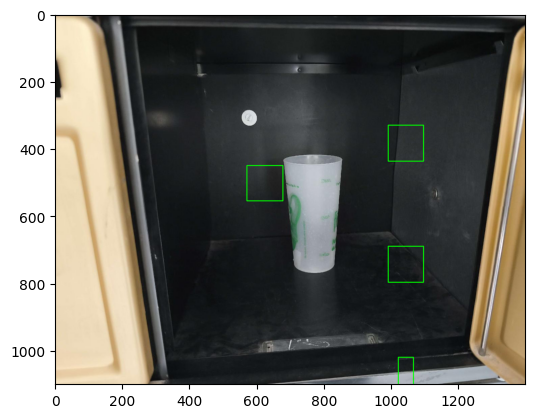

In [20]:
import importlib

import utils.detection
importlib.reload(utils.detection)
detect_ecocup = utils.detection.detect_ecocup

import utils.visual
importlib.reload(utils.visual)
draw_boxes_on_image = utils.visual.draw_boxes_on_image

idx = 7
img = imgs_test[idx]
img_rgb = imgs_test_rgb[idx]
detections = detect_ecocup(img, clf, HOG_extractor, min_ratio, max_ratio, min_scale, max_scale,px_step=30, scales_nb=2, ratios_nb=2, confidence_threshold=0.8)

# Affichage des résultats
hh = draw_boxes_on_image(img_rgb, detections)
plt.imshow(hh)